# Part 1: Preprocessing and PDF Feature Extraction

- preproccessing the pdfs data and save it into a pickle file.
- In order to save time, we decided to run the preprocessing and feature extraction on a single file from the cluster.
- We downloaded the pdf file of 2003 locally, and performed all the calculations on our computer.


Libraries

In [1]:
import os
import re
import sys
import warnings
import numpy as np
import pandas as pd
import PyPDF2
import json
import random
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import lxml
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import utils
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
import urllib.request
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Doc2Vec
from gensim.test.utils import common_texts
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from spacy.lang.en.stop_words import STOP_WORDS
import pickle
from collections import Counter

First of all, we imported the arxiv-metadata-oai-snapshot jason. \
This data will help us find the categories we want more easily because it has the ids.

In [ ]:
# import arxiv-metadata
arxiv_data = []
for line in open('arxiv-metadata-oai-snapshot.json', 'r'):
    arxiv_data.append(json.loads(line))
df = pd.DataFrame.from_records(arxiv_data)

In [ ]:
df = pd.DataFrame(df, columns = ['id', 'categories', 'update_date']) # select relevant columns
df['categories'] = df['categories'].apply(lambda x: x.split(' '))
df['category'] = [i[0] for i in df['categories']] # takes only the first category
df['year'] = [i[0:4] for i in df['update_date']]

## Proccessing

For our project, we decided to investigate the following categories:
*astro, cs, math, physics, stat*.

The following dataframe below will show us how many of each category we have in our local directory (In our local directory we have all of 2003 data)

In [ ]:
yoel_directory = 'Y:\\Data Science Readings\\big_data_project\\Downloaded_data\\2003\\2003'
nofar_directory = [x[0] for x in os.walk(os.getcwd())][3]
cluster_directory = '/sci/labs/orzuk/orzuk/teaching/big_data_project_52017/arxiv_data/full_papers/2003/'

directory = nofar_directory

file_names = [] # list of all pdfs in the 2003 folder
for file in os.listdir(directory):
    pdf_name = file.split('.pdf')[0]
    file_names.append(pdf_name)

In [ ]:
# sorting the 2003 PDF ID's
# taking the most updated version per ID
df_id = pd.DataFrame(directory_names, columns= ['full_id'])
df_id['full_id'] = [i if 'v' in i else i+'v1' for i in df_id['full_id']]
df_id['id'] = [i[0] for i in df_id['full_id'].str.split('v')]
df_id['v'] = [i[1] for i in df_id['full_id'].str.split('v')]
df_id = df_id.sort_values(['id','v'],ascending=[True,False])
df_id = df_id.groupby(['id']).first()

In [ ]:
# joining 2003 PDFs ID data with arxiv metadata 
left_df = df_id.merge(df, on='id', how='left').dropna()
left_df['main_category'] = left_df['category'].apply(lambda x: re.split(r"[-.]", x)) # split category and sub category
left_df['main_category'] = [i[0] for i in left_df['main_category']]
left_df = left_df[left_df['main_category'].str.match('|'.join(['math','cs','astro','physics','stat']))] # Keeping only selected categories
left_df.groupby('main_category').count()

In the 2003 folder we have:

- 1,071 Astrophysics pdfs 
- 4,129 Computer Science pdfs
- 3,178 Mathematics pdfs 
- 1,338 Physics pdfs
- 380 statistics pdfs


We decided to sample 350 (without replacement) pdfs of each of the above categories.

Before we start with the processing, we have to define some functions to help us process the data correctly.

In [ ]:
def remove_category(text):
    text = text.lower()
    categories = df["categories"].tolist()
    categories = [item for sublist in categories for item in sublist]
    all_categories = [category.lower() for category in set(categories)]
    for c in range(len(all_categories)):
        if all_categories[c] in text:
            text = text.replace(all_categories[c],'')
            text = text.replace('[]','')        
    return text


def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens


stopwords = list(STOP_WORDS)
def cleanText(text):
    wl = WordNetLemmatizer()
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.replace("\n", " ")
    text = text.lower()
    text = tokenize_text(text)
    text = [wl.lemmatize(word) for word in text if word not in stopwords]
    return text

**remove_category**: Removes the category of the pdf from the pdf. we noticed that some of the pdfs in our data have their categories printed at the top or at the bottom of the first page. We will show an example in the final summary paper. 
It is important to remove the category because it will prevent leaking of the data into the model.

**tokenize_text**: This function takes in a text input and tokenizes the sentence. We will only keep words which appeares more than twice in the whole dataset. It is common practice to remove words that are super rare, and we did that by removing the word if it appears just once in the text.

**cleanText function**:
This function performs lemmatization of the input,  Lemmatization is the process of grouping together different inflected forms of the same word. For example, words - > word, laughing, laughs, laughed -> laugh etc.


In [ ]:
def proccess_pdf(pdf_id):
    with open(os.path.join(directory,pdf_id+'.pdf'), 'rb') as pdfFileObj:  # Changes here
            pdfFile = PyPDF2.PdfReader(pdfFileObj,strict=False) # PdfFileReader
            full_text = [pdfFile.pages[i].extract_text() for i in range(len(pdfFile.pages))] # list of all pages
            full_text = '\n'.join(full_text)
            full_text = remove_category(full_text)
            full_text = cleanText(full_text)

    return(full_text)

**process_pdf**: Uses all the above functions in order to clean the text. The output is a processed text.

In [11]:
%%latex
\newpage

<IPython.core.display.Latex object>

## Sampling and vectorizing

The final step of part 1 is to sample 350 pdfs of each category that we've decided to process. \
We then vectorize the processed data using tfidsvectorizer. We tried different ways to vectorize the words but the accuracies / precision and confusion matrix were bad. Our best performance was with tfidsvectorizer. 

Note that some PDF files were problematic, and hence we had to use the try - except clauses. \
we kept the index of the good pdf data and this will be our final data for our models.

In [ ]:
warnings.filterwarnings("ignore")
df_sample_model = left_df.groupby('main_category').apply(lambda x: x.sample(350)).reset_index(drop=True)  
ID_list_model = df_sample_model['full_id'].tolist()
Y = df_sample_model['main_category'].tolist()
Y2 = df_sample_model['category'].tolist()
indx = []
X_word_list = []
for i in range(len(ID_list_model)):
    print("Iteration ",i)
    try:
        word_list = proccess_pdf(ID_list_model[i])
        X_word_list.append(word_list)
        indx.append(i)
    except:
        continue

In [ ]:
def vectorize(text, maxx_features):
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [ ]:
X_vectorize = [" ".join(word_list) for word_list in X_word_list]
X_vectorize = vectorize(X_vectorize ,500).toarray()
X_vectorize = [X_vectorize[i] for i in indx]

Saving the processed results into a pickle file, So we can use the data to build our models.

In [ ]:
Processed_Data = [X_vectorize, Y,indx]
with open('full_dataset', 'wb') as handle:
    pickle.dump(Processed_Data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
%%latex
\newpage

<IPython.core.display.Latex object>

# Part 2: Model Creation and Evaluation

Loading saved results:

In [2]:
with open('full_dataset', 'rb') as handle:
    Data = pickle.load(handle)

X = Data[0]
Y_temp = Data[1]
indx = Data[2]
categories_names = Counter(Y_temp)
categories_names = list(categories_names.keys())
Y = [Y_temp[i] for i in indx]

Creating Train test split for the models:

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state = 42)

Functions for model evaluation:

In [12]:
def calculate_accuracy(model,xtest,ytest):
    predictions = model.predict(xtest)
    n = len(predictions)
    correct = 0
    for i in range(len(predictions)):
        if predictions[i]==ytest[i]:
            correct +=1
    return round(correct / n,3)

def calculate_precision(model,xtest,ytest): 
    predictions = model.predict(xtest)
    totals = Counter(ytest)
    correct_preds = Counter(ytest)
    correct_preds = dict.fromkeys(correct_preds, 0)
    for i in range(len(predictions)):
        if predictions[i]==ytest[i]:
            correct_preds[ytest[i]]+=1
    accuracy={x:float(correct_preds[x])/totals[x] for x in totals}
    names = list(accuracy.keys())
    values = list(accuracy.values())
    return([names,values])


def bar_plot(model,xtest,ytest,model_name):
    model_list = []
    for i in range(len(model)):
        model_list.append(calculate_precision(model=model[i],xtest=X_test,ytest=y_test))
    
    model_dict = {model_name[i]: model_list[i][1] for i in range(len(model_name))}
    categories = model_list[0][0]
    
    x = np.arange(len(categories)) 
    width = 0.25 
    multiplier = 0
    colors_list = {model_name[i]: ['#a3a380','#efebce','#bb8588'][i] for i in range(len(model_name))}
    fig, ax = plt.subplots(layout='constrained',figsize=(10,5))

    for key, value in model_dict.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, value, width, label=key, color=colors_list[key])
        ax.bar_label(rects, padding=3, labels=[str(round(100*m,1))+'%' for m in value],fontsize=9)
        multiplier += 1

    ax.set_title('Model Precision',fontsize=14,fontweight='bold')
    ax.set_xticks(x + width, categories)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=3,fontsize=10)
    ax.set_ylim(0, 1.05)
    plt.tick_params(left = False , labelleft = False)
    plt.show()
        
    
def create_confusion_matrix(X,Y,model,labels,model_name=''):  
    Y_PRED = model.predict(X)
    cm = confusion_matrix(Y, Y_PRED)
    cm = cm/cm.sum(axis=1, keepdims=True)
    df_cm = pd.DataFrame(cm,labels,labels)
    plt.figure(figsize=(7,5))
    sns.set(font_scale=0.9)
    text = np.char.add((100*cm).round(1).astype(str), '%')
    sns.heatmap(df_cm, annot=text, annot_kws={"size": 10, 'color':'w'},cmap='flare',fmt='',vmin=0, vmax=1)
    model_name = 'Confusion Matrix: ' + model_name 
    plt.title(model_name,fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    plt.show()

## Model Comparison

In [5]:
model1 = LogisticRegression(C = 100, max_iter = 500).fit(X_train, y_train)
model2 = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
model3 =  MultinomialNB().fit(X_train, y_train)

In [6]:
models = [model1,model2,model3]
model_names = ['Logistic Regression','Multilayer Perceptron','Naive Bayes']
for i in range(3):
    print("The Accuracy of the %s is: %s" % (model_names[i], calculate_accuracy(model=models[i],xtest=X_test,ytest=y_test)))

The Accuracy of the Logistic Regression is: 0.829
The Accuracy of the Multilayer Perceptron is: 0.846
The Accuracy of the Naive Bayes is: 0.834


We can see that the Multilayer Perceptron has the best accuracy, but the three models has a very similar accuracies (~ 83%-85%)

### Category Comparison


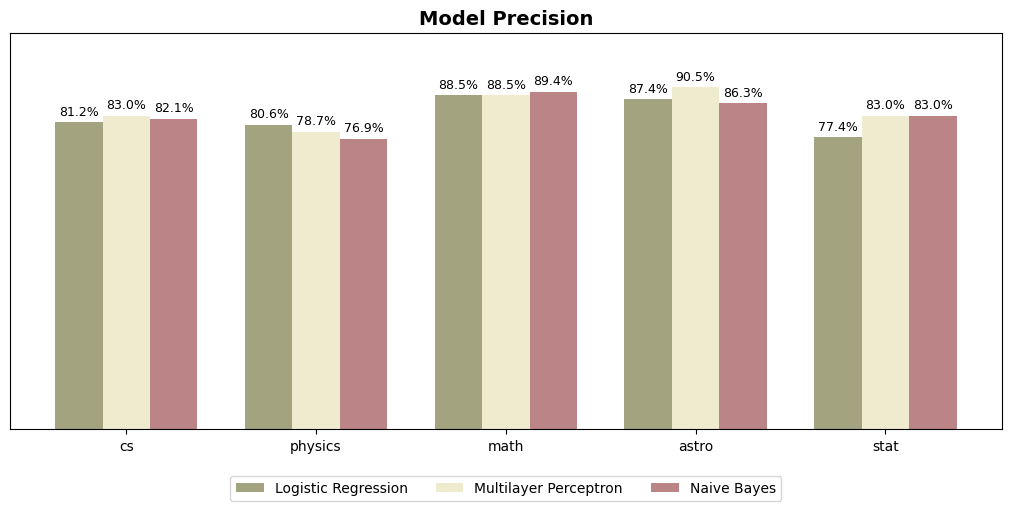

In [7]:
bar_plot(model = [model1,model2,model3],xtest=X_test,ytest=y_test,model_name=model_names)

Accuracy comparison within categories: 

- The Logistic Regression model has the best accuracy only in Physics (by 1.9-3.7 % points)
- The Naive Bayes model has the best accuracy only in Mathematics (by 0.9 % points)
- The Multilayer Perceptron model has the best accuracy in Computer Science and Astrophysics (by 0.9-1.8, 3.1-4.2 % points respectively)
- In Statistics both Multilayer Perceptron and Naive Bayes models got the best accuracies, which is 5.6 % points higher than the Logistic Regression model.

### Confusion Matrix
True Positive and False Positive by category (each row sums up to 100%)

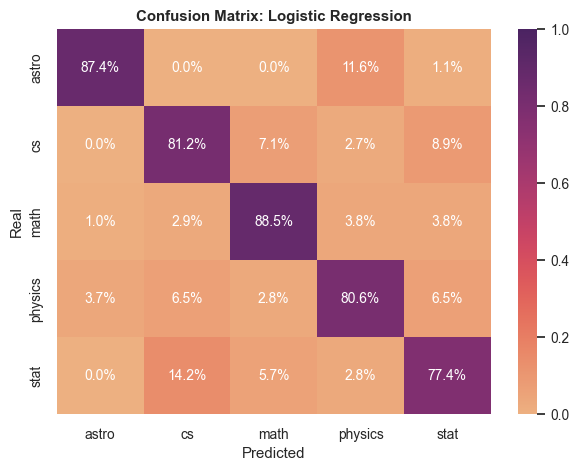

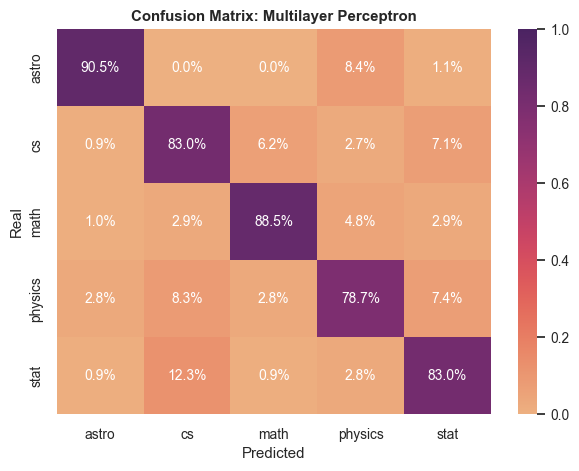

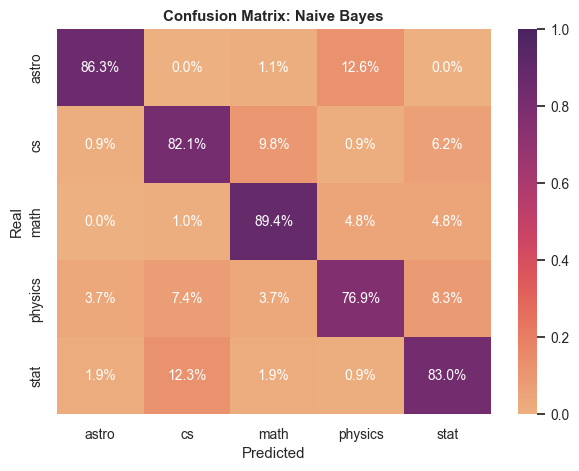

In [13]:
for i in range(3):
    create_confusion_matrix(X=X_test,Y=y_test,model=models[i],labels=categories_names,model_name=model_names[i])

**Similarities between categories:**

8.4-12.6% of Astrophysics papers were identified as Physics papers, but only 2.8-3.7% of Physics papers were identified as Astrophysics papers. It is not a surprising, since Astrophysics is a science that employs the methods and principles of physics and chemistry.

A large group (12.3-14.2%) of Statistics papers were identified as Computer Science, and 6.2-8.9% of Computer Science papers were identified as Statistics papers. Based on the metadata, We know that ~80% of the second category in Statistics papers is CS (which explains the large 'error'), while only ~8% of the second category in CS is Statistics.